# Sandbox environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
import agents
import environment
import utils 

# Critic analysis

**Idea:** to see if there is any error in the critic's code or if it works properly, we can use an optimal policy to gather trajectories and see if the critic learns from them the real value of the states under an optimal policy.

We have two ways in which the critic's target can be computed:
- Temporal Difference (TD) learning: $V(s) \approx \gamma V(s') + r(s,a)$
- Monte Carlo (MC) learning: $V(s) \approx \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'}$

The first one can be very biased by its nature, but in this simple taks should converge anyway.
The latter instead should be unbiased but more noisy.

## Optimal policy (hardcoded)
Use method get_optimal_action of the environment.

In [70]:
from importlib import reload
reload(agents)
reload(environment)
reload(utils)

<module 'utils' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/utils.py'>

<IPython.core.display.Javascript object>


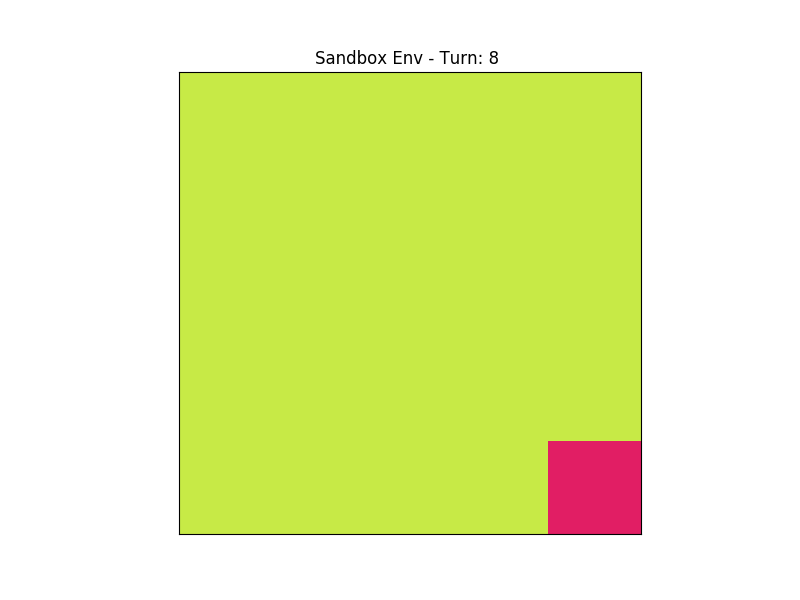

In [71]:
%matplotlib notebook
utils.render(x=5, y=5, goal=[4,4])
%matplotlib inline

## TD Critic Agent

In [72]:
from networks import DiscreteCritic

In [73]:
class CriticAgentTD():
    def __init__(self, observation_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.critic = DiscreteCritic(observation_space, project_dim)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def forward(self, state):
        state = torch.from_numpy(state)
        return self.critic(state)
    
    def update(self, rewards, states, done):
        rewards = torch.tensor(rewards) 
        old_states = torch.tensor(states[:-1]).view(1,-1)
        new_states = torch.tensor(states[1:]).view(1,-1)
        done = torch.LongTensor(done.astype(int))
        loss = self.update_critic(rewards, new_states, old_states, done)
        return loss
        
    def update_critic(self, rewards, new_states, old_states, done):
        # Predictions
        V_pred = self.critic(old_states).squeeze()
        # Targets
        V_trg = self.critic(new_states).squeeze()
        V_trg = (1-done)*self.gamma*V_trg + rewards
        # MSE loss
        loss = torch.sum((V_pred - V_trg)**2)
        # backprop and update
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        return loss.item()

In [74]:
def play_optimal(env):
    state = env.reset(random_init = True)
    
    rewards = []
    done = []
    states = [state]
    
    while True:
        action = env.get_optimal_action()
        
        new_state, reward, terminal, info = env.step(action) 
        states.append(new_state)
        rewards.append(reward)
        done.append(terminal)
        
        if terminal:
            break
            
        state = new_state
    
    return np.array(rewards), np.array(states), np.array(done)

In [75]:
def train_critic_TD(n_episodes = 100, lr = 0.01, gamma = 0.99):
    
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    
    observation_space = 10*10
    critic = CriticAgentTD(observation_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, states, done = play_optimal(env)
        
        loss = critic.update(rewards, states, done)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [76]:
G = 0.99
critic_TD, losses_TD = train_critic_TD(1000, lr=1e-2, gamma=G)

Episode 10 - loss: 0.5154
Episode 20 - loss: 0.1473
Episode 30 - loss: 0.0776
Episode 40 - loss: 0.0332
Episode 50 - loss: 0.0156
Episode 60 - loss: 0.0123
Episode 70 - loss: 0.0054
Episode 80 - loss: 0.0042
Episode 90 - loss: 0.0059
Episode 100 - loss: 0.0020
Episode 110 - loss: 0.0016
Episode 120 - loss: 0.0016
Episode 130 - loss: 0.0013
Episode 140 - loss: 0.0011
Episode 150 - loss: 0.0013
Episode 160 - loss: 0.0011
Episode 170 - loss: 0.0010
Episode 180 - loss: 0.0011
Episode 190 - loss: 0.0008
Episode 200 - loss: 0.0011
Episode 210 - loss: 0.0009
Episode 220 - loss: 0.0006
Episode 230 - loss: 0.0009
Episode 240 - loss: 0.0008
Episode 250 - loss: 0.0013
Episode 260 - loss: 0.0007
Episode 270 - loss: 0.0011
Episode 280 - loss: 0.0007
Episode 290 - loss: 0.0013
Episode 300 - loss: 0.0007
Episode 310 - loss: 0.0008
Episode 320 - loss: 0.0010
Episode 330 - loss: 0.0009
Episode 340 - loss: 0.0011
Episode 350 - loss: 0.0008
Episode 360 - loss: 0.0007
Episode 370 - loss: 0.0007
Episode 38

In [77]:
def plot_loss(losses, x='', y='', t='', xlog=False, ylog=False):
    episodes = np.arange(len(losses)) + 1
    plt.figure(figsize=(8,6))
    plt.plot(episodes, losses)
    plt.xlabel(x, fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.title(t, fontsize=16)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

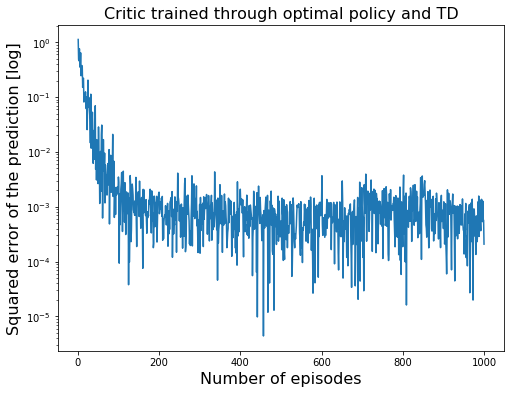

In [78]:
x = "Number of episodes"
y = "Squared error of the prediction [log]"
t = "Critic trained through optimal policy and TD"
plot_loss(losses_TD, x, y, t, ylog=True)

In [79]:
def get_real_value_map(env, gamma):
    distances = np.zeros((env.boundary[0], env.boundary[1] ))
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            d = env.dist_to_goal([x,y])
            distances[x,y] = d
    distances = distances.flatten() -1
    real_values = gamma**distances
    real_values[-1] = 1
    return real_values.reshape(env.boundary[0], env.boundary[1])

In [81]:
def value_map(critic, env, gamma):
    states = np.arange(env.boundary[0]*env.boundary[1]).reshape(1,-1)
    values = critic.forward(states).squeeze()
    values = values.detach().numpy().reshape(env.boundary[0], env.boundary[1])
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values[-1,-1] = 1
    plt.imshow(values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map", fontsize=16)
    plt.colorbar()
    
    real_values = get_real_value_map(env, gamma)
    plt.subplot(122)
    plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Real values", fontsize=16)
    plt.colorbar()
    
    plt.figure(figsize=(7,6))
    diff = values-real_values
    diff[-1,-1] = 0
    plt.imshow(diff)
    #plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Difference from real value", fontsize=16)
    plt.colorbar()
    

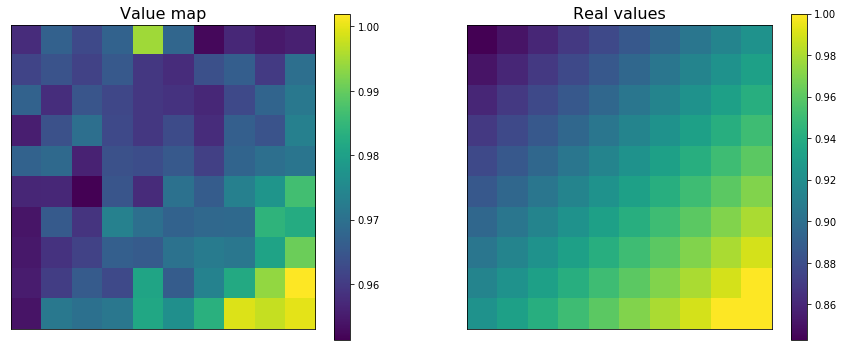

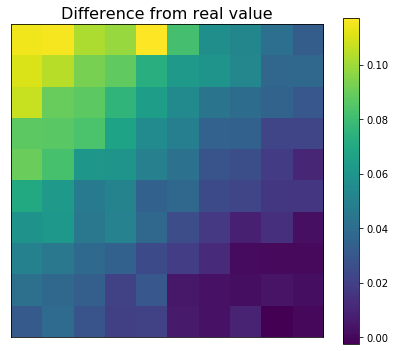

In [82]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic_TD, env, gamma = G)

### MC Critic Agent

In [83]:
class CriticAgentMC():
    def __init__(self, observation_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.critic = DiscreteCritic(observation_space, project_dim)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def forward(self, state):
        state = torch.from_numpy(state)
        return self.critic(state)
    
    def update(self, rewards, states, done):
        old_states = torch.tensor(states[:-1]).view(1,-1)
        new_states = torch.tensor(states[1:]).view(1,-1)
        
        loss = self.update_critic(rewards, old_states)
        return loss
        
    def update_critic(self, rewards, old_states):
        # Predictions
        V_pred = self.critic(old_states).squeeze()
        # Discount factors
        Gamma = np.array([self.gamma**i for i in range(rewards.shape[0])])
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(rewards[::-1]*Gamma[::-1])[::-1]
        # Rescale so that present reward is never discounted
        discounted_rewards =  Gt/Gamma
        dr = torch.tensor(discounted_rewards).float()    #.to(self.device)
        # MSE loss
        loss = torch.sum((V_pred - dr)**2)
        # backprop and update
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        return loss.item()

In [84]:
def train_critic_MC(n_episodes = 100, lr = 0.01, gamma = 0.99):
    # Create environment
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    
    observation_space = 10*10
    critic = CriticAgentMC(observation_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, states, done = play_optimal(env)
        
        loss = critic.update(rewards, states, done)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [85]:
critic_MC, losses_MC = train_critic_MC(1000, lr=1e-2)

Episode 10 - loss: 5.4408
Episode 20 - loss: 0.8387
Episode 30 - loss: 0.4717
Episode 40 - loss: 0.1433
Episode 50 - loss: 0.1513
Episode 60 - loss: 0.0783
Episode 70 - loss: 0.0528
Episode 80 - loss: 0.0244
Episode 90 - loss: 0.0201
Episode 100 - loss: 0.0158
Episode 110 - loss: 0.0116
Episode 120 - loss: 0.0112
Episode 130 - loss: 0.0161
Episode 140 - loss: 0.0058
Episode 150 - loss: 0.0164
Episode 160 - loss: 0.0058
Episode 170 - loss: 0.0127
Episode 180 - loss: 0.0150
Episode 190 - loss: 0.0057
Episode 200 - loss: 0.0044
Episode 210 - loss: 0.0042
Episode 220 - loss: 0.0066
Episode 230 - loss: 0.0037
Episode 240 - loss: 0.0054
Episode 250 - loss: 0.0035
Episode 260 - loss: 0.0064
Episode 270 - loss: 0.0026
Episode 280 - loss: 0.0024
Episode 290 - loss: 0.0011
Episode 300 - loss: 0.0016
Episode 310 - loss: 0.0042
Episode 320 - loss: 0.0045
Episode 330 - loss: 0.0013
Episode 340 - loss: 0.0042
Episode 350 - loss: 0.0027
Episode 360 - loss: 0.0020
Episode 370 - loss: 0.0005
Episode 38

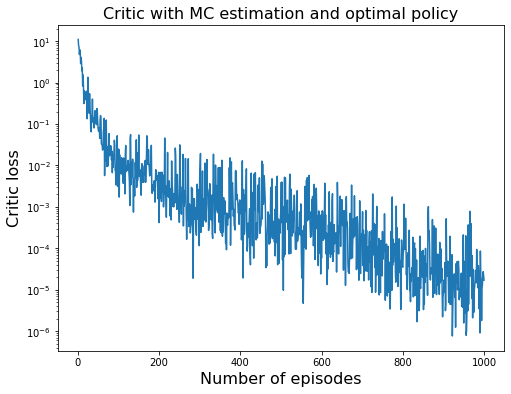

In [86]:
x = "Number of episodes"
y = "Critic loss"
t = "Critic with MC estimation and optimal policy"
plot_loss(losses_MC, x, y, t, ylog=True)

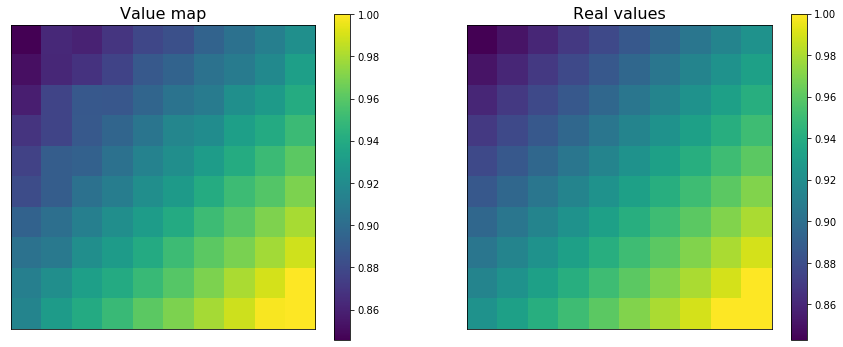

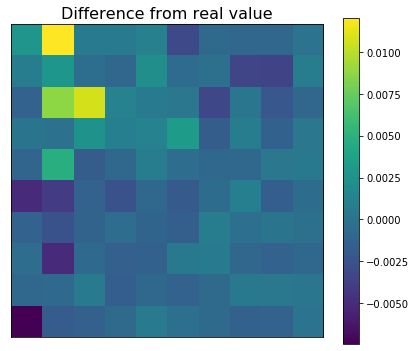

In [87]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic_MC, env, gamma = 0.99)

## Confrontation TD-MC

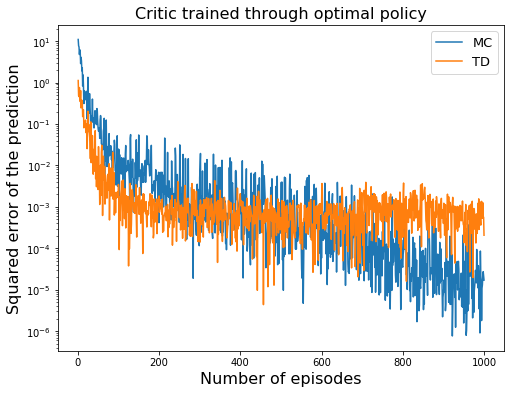

In [88]:
episodes = np.arange(len(losses_MC)) + 1
plt.figure(figsize=(8,6))
plt.plot(episodes, losses_MC, label='MC')
plt.plot(episodes, losses_TD, label='TD')
plt.xlabel("Number of episodes", fontsize=16)
plt.ylabel("Squared error of the prediction", fontsize=16)
plt.title("Critic trained through optimal policy", fontsize=16)
plt.yscale("log")
plt.legend(fontsize=13)
plt.show()

**Comment:** Using TD learning with the optimal actor feeding information is more efficient at the beginning, whereas in the long run MC learning is better.

In [89]:
def TD_vs_MC(TD_critic, MC_critic, env):
    states = np.arange(env.boundary[0]*env.boundary[1]).reshape(1,-1)
    values_TD = TD_critic.forward(states).squeeze()
    values_TD = values_TD.detach().numpy().reshape(env.boundary[0], env.boundary[1])

    values_MC = MC_critic.forward(states).squeeze()
    values_MC = values_MC.detach().numpy().reshape(env.boundary[0], env.boundary[1])
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values_TD[-1,-1] = 1
    plt.imshow(values_TD, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map TD", fontsize=16)
    plt.colorbar()

    plt.subplot(122)
    #plt.imshow(values-real_values)
    values_MC[-1,-1] = 1
    plt.imshow(values_MC, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map MC", fontsize=16)
    plt.colorbar()


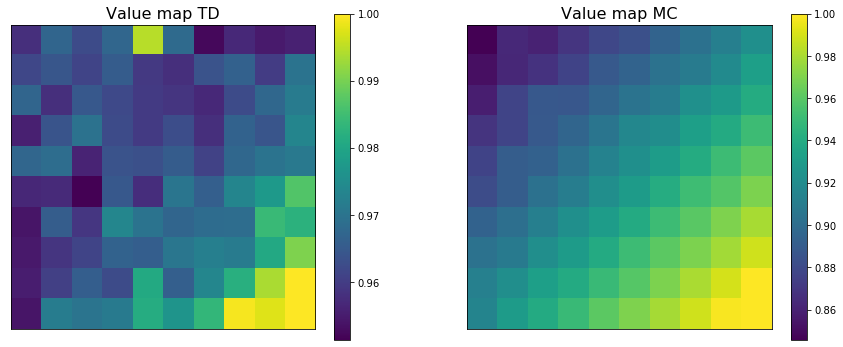

In [90]:
env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
TD_vs_MC(critic_TD, critic_MC, env)

## Actor analysis

**Idea:** substitute a critic with an hardcoded version that knows the optimal value of each cell, that is $\gamma^{d-1}$, considering
- a reward of 0 for all the steps except the one that bring the agent to the goal;
- a discount factor of $\gamma$;
- a distance (measured in minimum number of moves from A to B) d.

This means that the cells that are 1 step away form the goal have a value of 1, those 2 steps away of $\gamma$, 3 steps $\gamma^2$ and so on.

## TD actor
Using Temporal Difference estimation of the advantage with the optimal critic.

In [50]:
from networks import DiscreteActor
from torch.distributions import Categorical

In [59]:
class ActorAgentTD():
    def __init__(self, observation_space, action_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.actor = DiscreteActor(observation_space, action_space, project_dim)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
        
    def get_action(self, state, return_log=False, **kwargs):
        state = torch.from_numpy(state)
        log_probs = self.actor(state)
        dist = torch.exp(log_probs)
        probs = Categorical(dist)
        action =  probs.sample().item()
        if return_log:
            return action, log_probs.view(-1)[action]
        else:
            return action
    
    def critic(self, state, env):
        """Implements optimal critic given the sandbox environment."""
        #print("State.shape: ", state.shape)
        distances = []
        for s in state:
            s_decoded = [s//env.boundary[0], s%env.boundary[1]]
            #print("\n\tState %d decoded in (%d, %d)"%(s, s_decoded[0], s_decoded[1]))
            d = env.dist_to_goal(s_decoded)
            #print("\tGoal in (%d,%d)"%(env.goal[0], env.goal[1]))
            #print("\tDistance from goal: ", d)
            distances.append(d)
        distances = np.array(distances) -1
        values = torch.tensor(self.gamma**distances).float()
        #print("Distances: ", distances)
        #print("Values: ", values,'\n')
        return values
        
    
    def update(self, rewards, log_probs, states, done, env):
        rewards = torch.tensor(rewards) 
        old_states = states[:-1]
        new_states = states[1:]
        done = torch.LongTensor(done.astype(int))
        log_probs = torch.stack(log_probs)
        loss = self.update_actor(rewards, log_probs, new_states, old_states, done, env)
        return loss
        
    def update_actor(self, rewards, log_probs, new_states, old_states, done, env):
        # Get values from critic
        V_old = self.critic(old_states, env)
        V_new = self.critic(new_states, env)
        # Compute advantage as value(new_s) + reward - value(old_s)
        A = (1.-done)*V_new + rewards - V_old
        # Compute - gradient
        policy_gradient = - log_probs*A
        #print("policy_gradient ", policy_gradient.shape)
        # Use it as loss
        policy_grad = torch.sum(policy_gradient)
        # backprop and update
        self.actor_optim.zero_grad()
        policy_grad.backward()
        self.actor_optim.step()
        return policy_grad.item()


In [60]:
def train_actor_TD(n_episodes = 100, lr = 1e-2, gamma = 0.99):
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    actor = ActorAgentTD(observation_space, action_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(actor, env, return_states=True, update_online=False)
        loss = actor.update(rewards, log_probs, states, done, env)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return actor, losses

In [61]:
actor_TD, actor_loss_TD = train_actor_TD(1000)

Episode 10 - loss: -12.1437
Episode 20 - loss: -7.0883
Episode 30 - loss: -7.3059
Episode 40 - loss: -2.4117
Episode 50 - loss: -1.4741
Episode 60 - loss: -0.8905
Episode 70 - loss: -1.0756
Episode 80 - loss: -0.3705
Episode 90 - loss: -0.8270
Episode 100 - loss: 0.0000
Episode 110 - loss: -0.5204
Episode 120 - loss: -0.2768
Episode 130 - loss: -0.4006
Episode 140 - loss: -0.0080
Episode 150 - loss: -0.0012
Episode 160 - loss: 0.0014
Episode 170 - loss: 0.0012
Episode 180 - loss: 0.0094
Episode 190 - loss: -0.0021
Episode 200 - loss: -0.0032
Episode 210 - loss: -0.0076
Episode 220 - loss: -0.0028
Episode 230 - loss: -0.0035
Episode 240 - loss: -0.0037
Episode 250 - loss: 0.0007
Episode 260 - loss: -0.0044
Episode 270 - loss: 0.0006
Episode 280 - loss: 0.0006
Episode 290 - loss: 0.0006
Episode 300 - loss: -0.0041
Episode 310 - loss: -0.0082
Episode 320 - loss: -0.0103
Episode 330 - loss: -0.0036
Episode 340 - loss: 0.0004
Episode 350 - loss: 0.0071
Episode 360 - loss: -0.0045
Episode 37

<IPython.core.display.Javascript object>


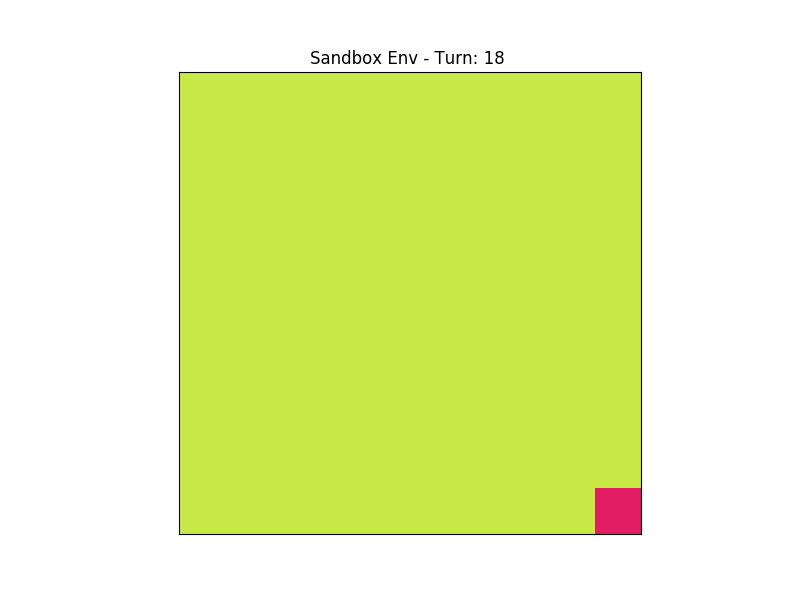

In [62]:
%matplotlib notebook
utils.render(actor_TD, x=10, y=10, goal=[9,9])
%matplotlib inline

## MC actor

In [96]:
class ActorAgentMC():
    def __init__(self, observation_space, action_space, lr, gamma, project_dim=8):
        self.gamma = gamma
        self.lr = lr
        self.actor = DiscreteActor(observation_space, action_space, project_dim)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
        
    def get_action(self, state, return_log=False, **kwargs):
        state = torch.from_numpy(state)
        log_probs = self.actor(state)
        dist = torch.exp(log_probs)
        probs = Categorical(dist)
        action =  probs.sample().item()
        if return_log:
            return action, log_probs.view(-1)[action]
        else:
            return action
    
    def critic(self, state, env):
        """Implements optimal critic given the sandbox environment."""
        #print("State.shape: ", state.shape)
        distances = []
        for s in state:
            s_decoded = [s//env.boundary[0], s%env.boundary[1]]
            #print("\n\tState %d decoded in (%d, %d)"%(s, s_decoded[0], s_decoded[1]))
            d = env.dist_to_goal(s_decoded)
            #print("\tGoal in (%d,%d)"%(env.goal[0], env.goal[1]))
            #print("\tDistance from goal: ", d)
            distances.append(d)
        distances = np.array(distances) -1
        values = torch.tensor(self.gamma**distances).float()
        #print("Distances: ", distances)
        #print("Values: ", values,'\n')
        return values
        
    
    def update(self, rewards, log_probs, states, done, env):
        Gamma = np.array([self.gamma**i for i in range(rewards.shape[0])])
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(rewards[::-1]*Gamma[::-1])[::-1]
        # Rescale so that present reward is never discounted
        discounted_rewards =  Gt/Gamma
        
        # Wrap variables in tensors
        dr = torch.tensor(discounted_rewards).float()  
        old_states = states[:-1]
        new_states = states[1:]
        done = torch.LongTensor(done.astype(int))
        log_probs = torch.stack(log_probs)
        loss = self.update_actor(dr, log_probs, old_states, env)
        return loss
        
    def update_actor(self, dr, log_probs, old_states, env):
        # Get values from critic
        V_old = self.critic(old_states, env)
        # Compute advantage as total return - value(s)
        A = dr - V_old
        # Compute - gradient
        policy_gradient = - log_probs*A
        # Use it as loss
        policy_grad = torch.sum(policy_gradient)
        # backprop and update
        self.actor_optim.zero_grad()
        policy_grad.backward()
        self.actor_optim.step()
        return policy_grad.item()


In [97]:
def train_actor_MC(n_episodes = 100, lr = 1e-2, gamma = 0.99):
    env = environment.Sandbox(10, 10, [0,0], [9,9], max_steps=100)
    observation_space = 10*10
    action_space = 4
    actor = ActorAgentMC(observation_space, action_space, lr, gamma)
    
    losses = []
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(actor, env, return_states=True, update_online=False)
        loss = actor.update(rewards, log_probs, states, done, env)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return actor, losses

In [98]:
actor_MC, actor_loss_MC = train_actor_MC(1000)

Episode 10 - loss: -1160.5309
Episode 20 - loss: -620.0946
Episode 30 - loss: -507.1217
Episode 40 - loss: -453.8450
Episode 50 - loss: -751.6483
Episode 60 - loss: -727.1900
Episode 70 - loss: -305.1431
Episode 80 - loss: -396.1922
Episode 90 - loss: -606.3565
Episode 100 - loss: -833.2600
Episode 110 - loss: -461.0832
Episode 120 - loss: -442.1971
Episode 130 - loss: -423.4992
Episode 140 - loss: -565.6263
Episode 150 - loss: -534.5168
Episode 160 - loss: -412.3009
Episode 170 - loss: -360.8327
Episode 180 - loss: -46.8850
Episode 190 - loss: -32.1120
Episode 200 - loss: -37.8061
Episode 210 - loss: -43.0875
Episode 220 - loss: -39.1223
Episode 230 - loss: -25.9562
Episode 240 - loss: -5.0695
Episode 250 - loss: -16.5309
Episode 260 - loss: -29.8819
Episode 270 - loss: -8.4494
Episode 280 - loss: -7.1883
Episode 290 - loss: -7.8233
Episode 300 - loss: -4.3377
Episode 310 - loss: -2.0228
Episode 320 - loss: -14.8143
Episode 330 - loss: -11.2934
Episode 340 - loss: -0.0461
Episode 350 

<IPython.core.display.Javascript object>


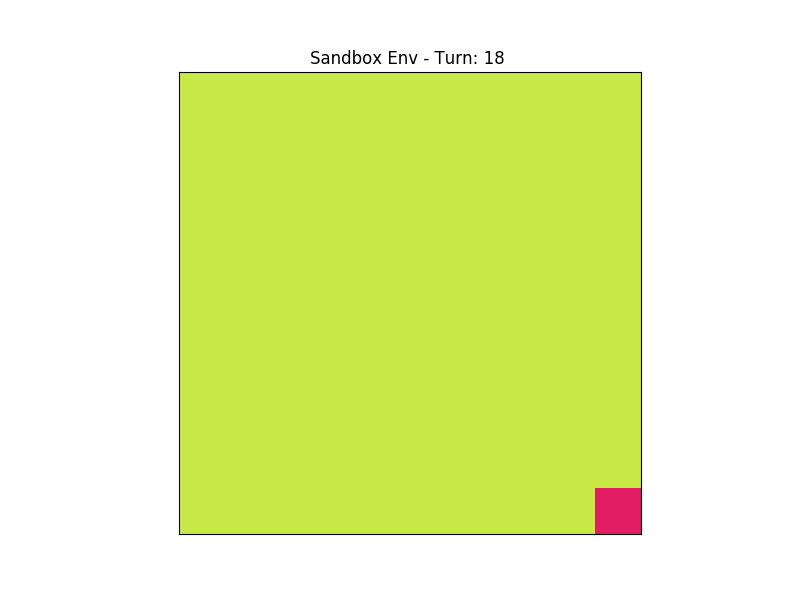

In [99]:
%matplotlib notebook
utils.render(actor_MC, x=10, y=10, goal=[9,9])
%matplotlib inline

**Comment:** both actors learn correctly the optimal policy if the advantages we provide for the update are computed by an optimal critic. Also we've seen that both the critics learn correctly if feeded trajectories made by an optimal actor. The last thing that we need to be sure of is that no numerical instability arises by coupling the two learning processes.

## Actor-Critic with MC estimation

In [144]:
import ActorCritic
reload(ActorCritic)

<module 'ActorCritic' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/ActorCritic.py'>

In [158]:
def train_sandbox_A2C(n_episodes = 100, lr = 1e-2, gamma = 0.99, TD=False):
    # Create environment
    env = environment.Sandbox(5, 5, [0,0], [4,4], max_steps=100)
    observation_space = 10*10
    action_space = 4
    # Init agent
    agent = ActorCritic.A2C(observation_space, action_space, lr, gamma, TD=TD, discrete=True, project_dim=16)
    performance = []
    critic_losses = []
    actor_losses = []
    
    for e in range(n_episodes):
        rewards, log_probs, states, done = play_episode_A2C(agent, env, return_states=True, update_online=False)
        critic_loss, actor_loss = agent.update(rewards, log_probs, states, done)
        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)
        performance.append(np.sum(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f"%(e+1, np.mean(performance[-10:])))

    return agent, np.array(performance), np.array(critic_losses), np.array(actor_losses)

In [159]:
MC_A2C, MC_reward, MC_critic_loss, MC_actor_loss = train_sandbox_A2C(500, TD=False)

Episode 10 - reward: -6.60
Episode 20 - reward: -0.60
Episode 30 - reward: -0.50
Episode 40 - reward: -1.10
Episode 50 - reward: -0.70
Episode 60 - reward: 0.20
Episode 70 - reward: 0.80
Episode 80 - reward: 0.60
Episode 90 - reward: 0.60
Episode 100 - reward: 0.60
Episode 110 - reward: 1.00
Episode 120 - reward: 0.80
Episode 130 - reward: 1.00
Episode 140 - reward: 1.00
Episode 150 - reward: 1.00
Episode 160 - reward: 1.00
Episode 170 - reward: 0.90
Episode 180 - reward: 0.90
Episode 190 - reward: 1.00
Episode 200 - reward: 1.00
Episode 210 - reward: 1.00
Episode 220 - reward: 0.90
Episode 230 - reward: 1.00
Episode 240 - reward: 1.00
Episode 250 - reward: 1.00
Episode 260 - reward: 1.00
Episode 270 - reward: 1.00
Episode 280 - reward: 1.00
Episode 290 - reward: 1.00
Episode 300 - reward: 1.00
Episode 310 - reward: 1.00
Episode 320 - reward: 1.00
Episode 330 - reward: 1.00
Episode 340 - reward: 1.00
Episode 350 - reward: 1.00
Episode 360 - reward: 1.00
Episode 370 - reward: 1.00
Episo

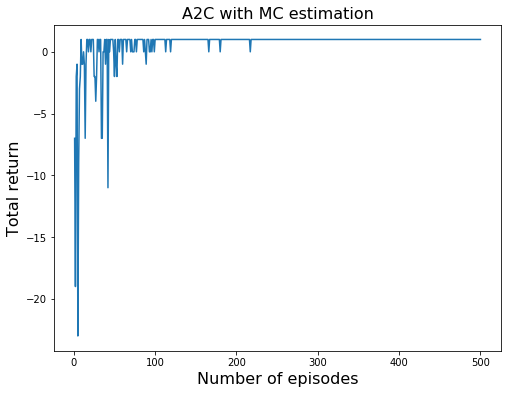

In [160]:
x = "Number of episodes"
y = "Total return"
t = "A2C with MC estimation"
plot_loss(MC_reward, x, y, t)

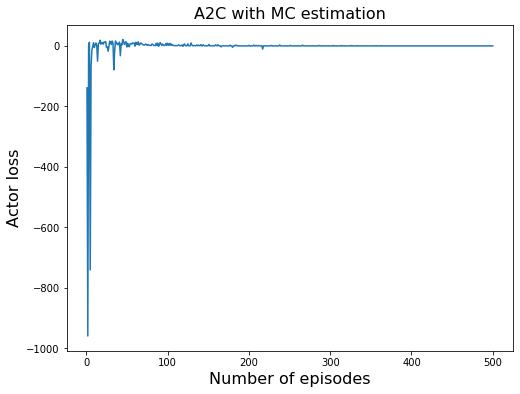

In [161]:
x = "Number of episodes"
y = "Actor loss"
t = "A2C with MC estimation"
plot_loss(MC_actor_loss, x, y, t)

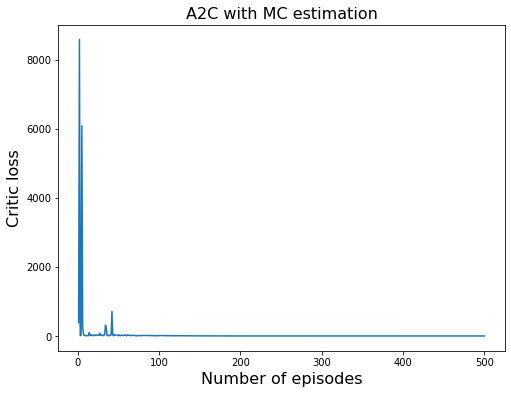

In [162]:
x = "Number of episodes"
y = "Critic loss"
t = "A2C with MC estimation"
plot_loss(MC_critic_loss, x, y, t)

<IPython.core.display.Javascript object>


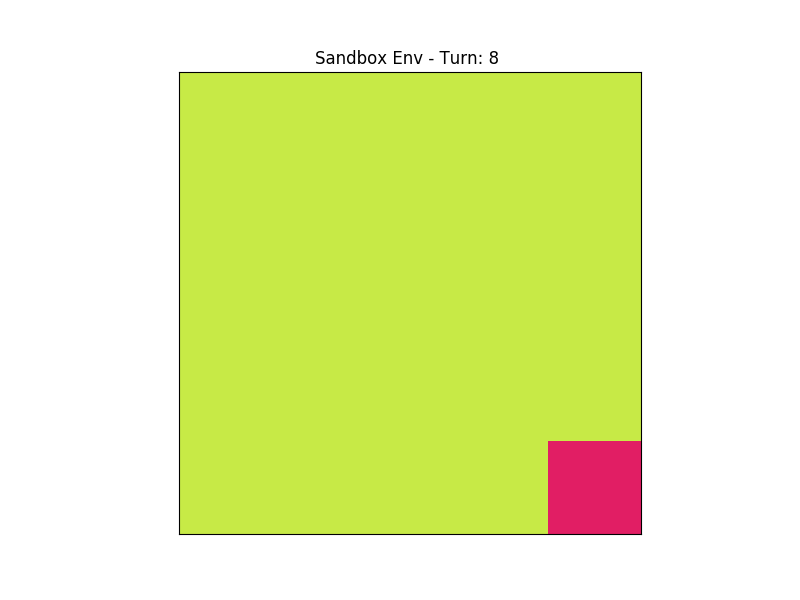

In [163]:
%matplotlib notebook
utils.render(MC_A2C, x=5, y=5, goal=[4,4])
%matplotlib inline

## Actor-Critic with TD estimation

In [164]:
import ActorCritic
reload(ActorCritic)

<module 'ActorCritic' from '/home/nicola/Nicola_unipd/MasterThesis/Policy-based-RL/ActorCritic.py'>

In [165]:
TD_A2C, TD_reward, TD_critic_loss, TD_actor_loss = train_sandbox_A2C(500, TD=True)

Episode 10 - reward: -8.70
Episode 20 - reward: 0.40
Episode 30 - reward: 0.60
Episode 40 - reward: 1.00
Episode 50 - reward: 1.00
Episode 60 - reward: 1.00
Episode 70 - reward: 1.00
Episode 80 - reward: 1.00
Episode 90 - reward: 1.00
Episode 100 - reward: 1.00
Episode 110 - reward: 1.00
Episode 120 - reward: 1.00
Episode 130 - reward: 1.00
Episode 140 - reward: 1.00
Episode 150 - reward: 1.00
Episode 160 - reward: 1.00
Episode 170 - reward: 1.00
Episode 180 - reward: 1.00
Episode 190 - reward: 1.00
Episode 200 - reward: 1.00
Episode 210 - reward: 1.00
Episode 220 - reward: 1.00
Episode 230 - reward: 1.00
Episode 240 - reward: 1.00
Episode 250 - reward: 1.00
Episode 260 - reward: 1.00
Episode 270 - reward: 1.00
Episode 280 - reward: 1.00
Episode 290 - reward: 1.00
Episode 300 - reward: 1.00
Episode 310 - reward: 1.00
Episode 320 - reward: 1.00
Episode 330 - reward: 1.00
Episode 340 - reward: 1.00
Episode 350 - reward: 1.00
Episode 360 - reward: 1.00
Episode 370 - reward: 1.00
Episode 3

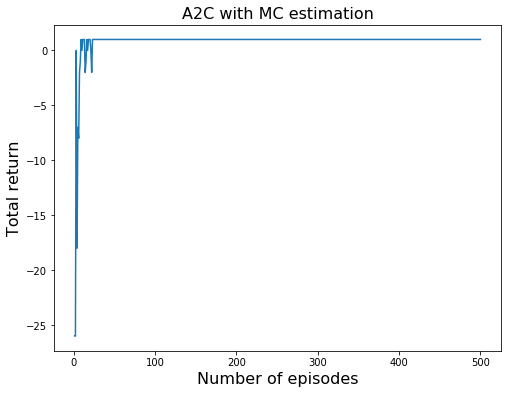

In [166]:
x = "Number of episodes"
y = "Total return"
t = "A2C with MC estimation"
plot_loss(TD_reward, x, y, t)

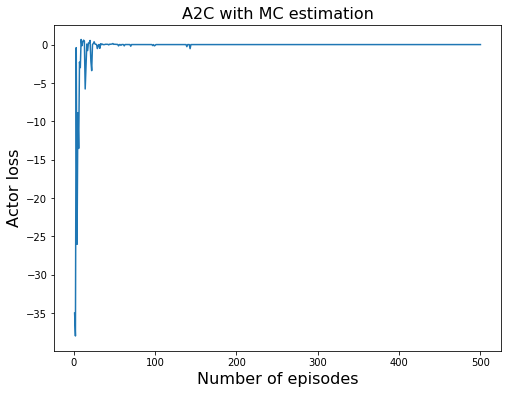

In [167]:
x = "Number of episodes"
y = "Actor loss"
t = "A2C with MC estimation"
plot_loss(TD_actor_loss, x, y, t)

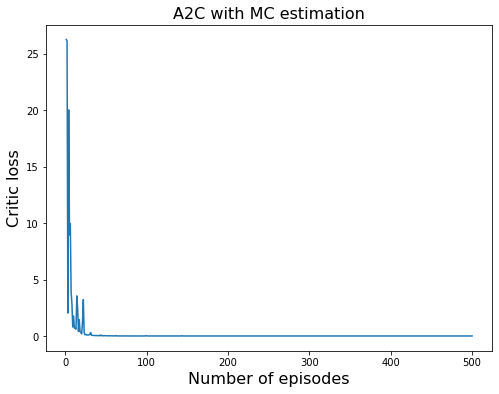

In [168]:
x = "Number of episodes"
y = "Critic loss"
t = "A2C with MC estimation"
plot_loss(TD_critic_loss, x, y, t)

<IPython.core.display.Javascript object>


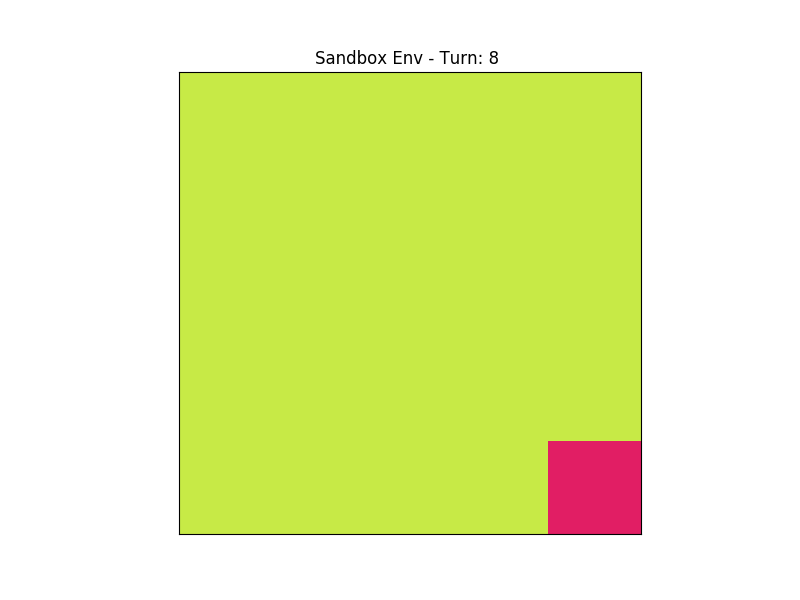

In [169]:
%matplotlib notebook
utils.render(TD_A2C, x=5, y=5, goal=[4,4])
%matplotlib inline

**Comment:** Both agent can learn the optimal policy IF during the initial phase are able to encounter the goal. Being the reward not much informative, they always learn to avoid hitting the borders of the map, but TD agent seems to learn the optimal policy only when the map is small enough to find it randomly. To be sure of the successfull learning one should find some ways to introduce exploration in this Actor-Critic setup, that as it is is devoted only to exploitation.